# Time Series Machine Learning
use the tf.data api to use machine learning to predict the future.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [18]:
def window_dataset(series, window_size:int, batch_size:int=32):
    """
    From a time series, create a set of learnable windows.
    
    Parameters
    ---------
    Series
        The series to learn
    Window size
        the size of window to learn from
    batch size
        The size of each batch in the dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # We want windows of the same length!
    # We also want batches of the window size
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    # Use the previous window_size-1 data points to predict the next one, and shuffle the windows.
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(len(series))
    return dataset.batch(batch_size).prefetch(1)


## Time Series generation
Here are some functions to generate a seasonal, noisy time series

In [33]:
def trend(time:np.array, slope: float) -> np.array:
    return (slope * time)

def seasonal_pattern(season_time: np.array):
    """
    This is arbitrary -- there could be multiple seasonal patterns.
    """
    return np.where(
        season_time < 0.4, np.cos(season_time * 2 * np.pi), np.exp(-3 * season_time)
    )


def seasonality(time: np.array, period: float, amplitude: float = 1, phase: float = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time: np.array, noise_level: float, seed: int = 31415926):
    rng = np.random.default_rng(seed=seed)
    return rng.random(time.shape[0]) * noise_level

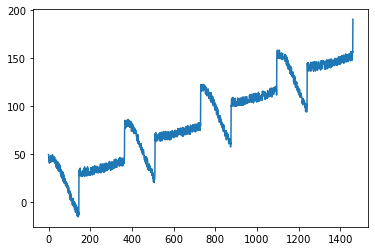

In [37]:
time = np.arange(4*365 + 1)
series = seasonality(time, period=365, amplitude=40) + white_noise(time, 10) + trend(time, 0.1)

split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.plot(time, series)

## Learning
First up, linear regression.

In [41]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

lin_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
lin_model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.Huber(),
                 metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [42]:
lin_model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 37.1954 - mae: 37.6910 - val_loss: 19.6083 - val_mae: 20.1072
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 8.6636 - mae: 9.1507 - val_loss: 7.5886 - val_mae: 8.0681
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 7.0241 - mae: 7.5101 - val_loss: 7.1158 - val_mae: 7.6013
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 7.7281 - mae: 8.2172 - val_loss: 6.8025 - val_mae: 7.2862
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 6.7409 - mae: 7.2225 - val_loss: 7.5972 - val_mae: 8.0784
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 6.6950 - mae: 7.1734 - val_loss: 6.2246 - val_mae: 6.7063
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 6.7518 - mae: 7.2290 - val_loss: 6.9802 - val_mae: 7.4577
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6.4339

31/31 [==============================] - 0s 4ms/step - loss: 3.7155 - mae: 4.1912 - val_loss: 3.8626 - val_mae: 4.3250
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9909 - mae: 4.4653 - val_loss: 3.7609 - val_mae: 4.2336
Epoch 65/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9740 - mae: 4.4475 - val_loss: 3.7564 - val_mae: 4.2311
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5108 - mae: 4.9846 - val_loss: 4.1394 - val_mae: 4.6136
Epoch 67/500
31/31 [==============================] - 0s 4ms/step - loss: 3.7933 - mae: 4.2654 - val_loss: 3.8060 - val_mae: 4.2839
Epoch 68/500
31/31 [==============================] - 0s 4ms/step - loss: 3.9350 - mae: 4.4097 - val_loss: 4.2507 - val_mae: 4.7254
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 3.8383 - mae: 4.3123 - val_loss: 4.1429 - val_mae: 4.6236
Epoch 70/500
31/31 [==============================] - 0s 4ms/step - loss: 3.7235 - mae: 4

In [46]:
def model_forecast(model, series, window_size:int):
    """
    Use a model to predict a small range into the future.
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)

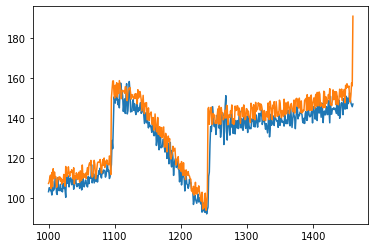

In [53]:
lin_forecast = model_forecast(lin_model, series[split_time - window_size:-1], window_size)[:, 0]
plt.plot(time_valid, lin_forecast)
plt.plot(time_valid, x_valid)

In [56]:
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation=tf.keras.activations.relu,
                          input_shape=[window_size]),
    tf.keras.layers.Dense(10, tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
])
mlp_model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.Huber(),
                 metrics=["mae"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [57]:
mlp_model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 8ms/step - loss: 101.5031 - mae: 102.0025 - val_loss: 73.2855 - val_mae: 73.7855
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 18.2622 - mae: 18.7563 - val_loss: 8.3598 - val_mae: 8.8364
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 10.0355 - mae: 10.5200 - val_loss: 8.9336 - val_mae: 9.4256
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 8.6550 - mae: 9.1373 - val_loss: 7.4759 - val_mae: 7.9588
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 8.4654 - mae: 8.9484 - val_loss: 8.3535 - val_mae: 8.8440
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 8.2503 - mae: 8.7286 - val_loss: 7.0112 - val_mae: 7.4858
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2666 - mae: 7.7470 - val_loss: 6.8864 - val_mae: 7.3628
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 

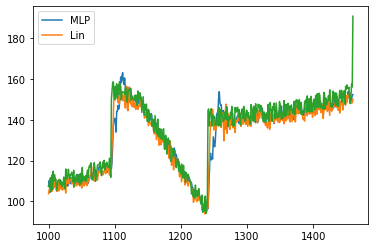

In [63]:
mlp_forecast = model_forecast(mlp_model, series[split_time - window_size:-1], window_size)[:, 0]
lin_forecast = model_forecast(lin_model, series[split_time - window_size:-1], window_size)[:, 0]
plt.plot(time_valid, mlp_forecast, label="MLP")
plt.plot(time_valid, lin_forecast, label="Lin")
plt.plot(time_valid, x_valid)
plt.legend()